# Image Quality Enhancement

### Image Denoising with Autoencoder

### Introduction

Image denoising is a crucial step in image processing and computer vision, aimed at removing noise from images while preserving important details. Various methods exist for denoising images, ranging from traditional filtering techniques to advanced machine learning models. This notebook focuses on evaluating the performance of an autoencoder-based denoising approach and comparing it to several classical image filtering techniques.

### Objective

The primary objectives of this notebook are:

1. **Implement and Train an Autoencoder Model**: An autoencoder is a type of neural network used for unsupervised learning tasks, including image denoising. We will train an autoencoder on noisy images and evaluate its performance in denoising.

2. **Compare Denoising Techniques**: We will compare the autoencoder's performance with several traditional filtering methods, including Median, Gaussian, Average, and Bilateral Filters. This comparison will help us understand how well the autoencoder performs relative to these classical methods.

3. **Evaluate and Visualize Results**: We will use Peak Signal-to-Noise Ratio (PSNR) to quantify the quality of denoising. PSNR is a common metric used to measure the quality of reconstructed images by comparing them to the original noisy images. Higher PSNR values indicate better image quality.

### Dataset

The dataset used in this notebook is custom-made and consists of noisy images and their corresponding clean versions. As the dataset is not publicly available, the results and comparisons are specific to this dataset.

### Methods

#### Autoencoder

An autoencoder is a type of neural network that learns to compress and then reconstruct data. For image denoising, the autoencoder is trained to map noisy images to clean images. The architecture includes:

- **Encoder**: Compresses the input image into a lower-dimensional representation.
- **Decoder**: Reconstructs the image from the compressed representation.

#### Traditional Filters

We will compare the autoencoder with the following classical filters:

- **Median Filter**: Replaces each pixel's value with the median value of the pixel's neighborhood.
- **Gaussian Filter**: Applies a Gaussian function to blur the image and reduce noise.
- **Average Filter**: Replaces each pixel's value with the average of the pixel's neighborhood.
- **Bilateral Filter**: Preserves edges while reducing noise by considering both spatial distance and pixel intensity.

### Evaluation Metrics

- **Peak Signal-to-Noise Ratio (PSNR)**: Measures the quality of the denoised image by comparing it to the original noisy image. Higher PSNR values indicate better quality.

## Conclusion

Through this notebook, we aim to demonstrate the effectiveness of the autoencoder in denoising images and compare its performance against traditional filtering techniques. By visualizing and analyzing the results, we will gain insights into the strengths and limitations of different denoising methods.

---

Let's proceed with loading the data, training the autoencoder model, and evaluating the results.


In [1]:
import numpy as np
import pandas as pd
import os
from keras.preprocessing import image
import matplotlib.pyplot as plt
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, MaxPooling2D,MaxPool2D ,UpSampling2D, Flatten, Input,BatchNormalization , Add
from keras.optimizers import SGD, Adam, Adadelta, Adagrad
from keras import backend as K
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
import cv2
from math import log10,sqrt

2024-08-21 20:05:38.673530: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-21 20:05:38.673633: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-21 20:05:38.815059: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
train_images=sorted(os.listdir('/kaggle/input/images/Images'))

In [3]:
train_image=[]
for im in train_images:
  img=image.load_img('/kaggle/input/images/Images/'+im,target_size=(64,64),color_mode='grayscale')
  img=image.img_to_array(img)
  img=img/255
  train_image.append(img)

train_df=np.array(train_image)

In [4]:
def plot_img(dataset):
  f,ax=plt.subplots(1,5)
  f.set_size_inches(40,20)
  for i in range(5,10):
    ax[i-5].imshow(dataset[i].reshape(64,64), cmap='gray')
  plt.show()

In [5]:
noised_images=sorted(os.listdir('/kaggle/input/noised-images/low_quality_images'))

noised_image=[]

for im in noised_images:
  img=image.load_img('/kaggle/input/noised-images/low_quality_images/'+im,target_size=(64,64),color_mode='grayscale')
  img=image.img_to_array(img)
  img=img/255
  noised_image.append(img)

noised_df=np.array(noised_image)

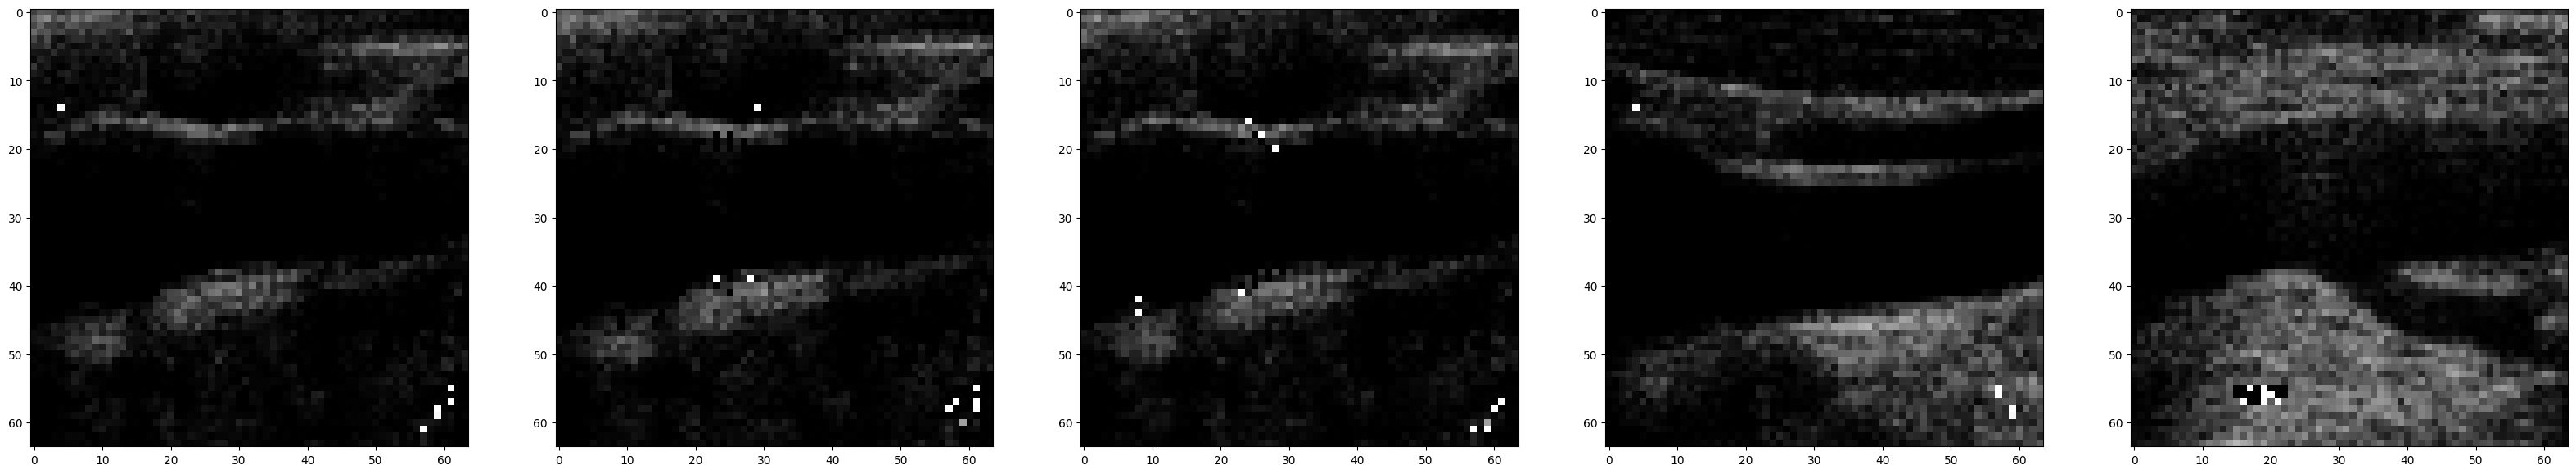

In [6]:
plot_img(train_df)

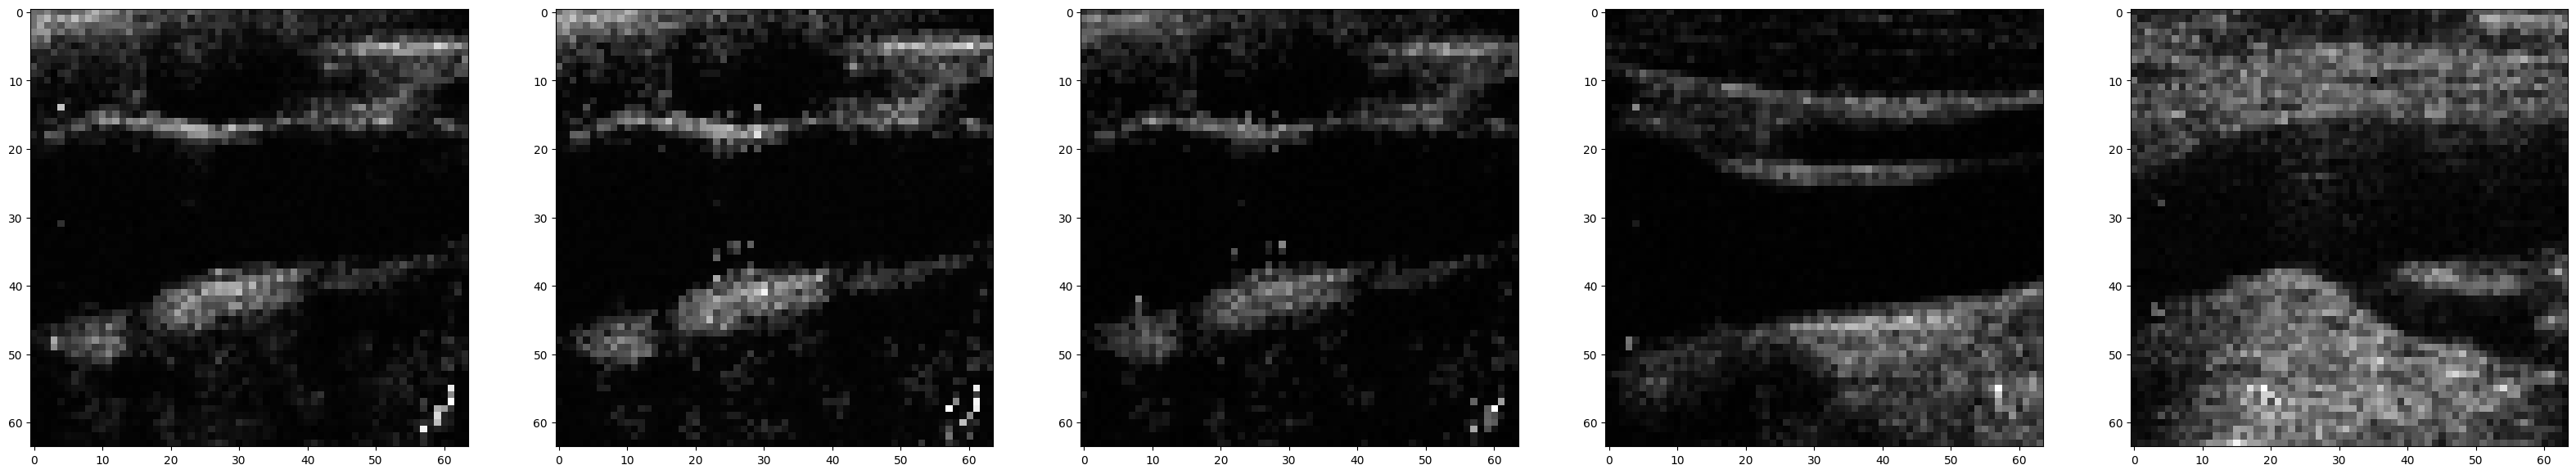

In [7]:
plot_img(noised_df)

In [8]:
xnoised=noised_df[:4000]
xtest=noised_df[4000:]

This is an autoencoder model designed to reconstruct 64x64 grayscale images. The network consists of an encoder with convolutional layers and max pooling to extract features and reduce dimensions, followed by a bottleneck layer that compresses these features. 
The decoder then upsamples and reconstructs the image through additional convolutional layers, with a residual connection that adds the original image to the output to preserve details. The model is compiled using the Adam optimizer and mean squared error loss to optimize the reconstruction accuracy.

In [9]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, UpSampling2D, Add
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def autoencoder():
    input_img = Input(shape=(64, 64, 1), name='image_input')

    # Encoder
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(input_img)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)

    # Bottleneck
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)

    # Decoder
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D((2, 2))(x)

    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D((2, 2))(x)

    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    # Residual Connection
    output = Add()([decoded, input_img])

    autoencoder = Model(inputs=input_img, outputs=output)
    autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    
    return autoencoder


Input Layer: The model starts with an input layer accepting grayscale images of size 64x64 pixels.

Encoder:

Convolutional Layers: Two convolutional layers with 128 and 64 filters, respectively, followed by batch normalization and max pooling. These layers extract features and reduce spatial dimensions.

Bottleneck: A convolutional layer with 32 filters to capture compressed features.

Decoder:

Upsampling Layers: Two convolutional layers with 64 and 128 filters, respectively, followed by upsampling to reconstruct the image dimensions.

Output Layer: A final convolutional layer with a sigmoid activation function to generate the reconstructed image.

Residual Connection: Adds the original input image to the reconstructed output to retain original image details.

Compilation: The model is compiled with the Adam optimizer and mean squared error loss function.

In [10]:
model= autoencoder()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 64, 64, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 64, 64,    │      1,280 │ image_input[0][0] │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 64, 64,    │        512 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 32, 32,    │     73,792 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 16, 16,    │     18,464 │ max_pooling2d_1[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        128 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 16, 16,    │     18,496 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (UpSampling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │     73,856 │ up_sampling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        512 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_1     │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (UpSampling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64, 1) │      1,153 │ up_sampling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 64, 64, 1) │          0 │ conv2d_5[0][0],   │
│                     │                   │            │ image_input[0][0

 Total params: 188,705 (737.13 KB)

 Trainable params: 187,873 (733.88 KB)

 Non-trainable params: 832 (3.25 KB)

Epoch 1/20
 15/125 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.2860

I0000 00:00:1724271017.414366     108 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1624
Epoch 1: val_loss improved from inf to 0.00270, saving model to /kaggle/working/best_autoencoder.keras
125/125 ━━━━━━━━━━━━━━━━━━━━ 14s 39ms/step - loss: 0.1617 - val_loss: 0.0027
Epoch 2/20
121/125 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0015
Epoch 2: val_loss improved from 0.00270 to 0.00051, saving model to /kaggle/working/best_autoencoder.keras
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0015 - val_loss: 5.1039e-04
Epoch 3/20
121/125 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.3591e-04
Epoch 3: val_loss improved from 0.00051 to 0.00022, saving model to /kaggle/working/best_autoencoder.keras
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 4.3295e-04 - val_loss: 2.2105e-04
Epoch 4/20
121/125 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.1339e-04
Epoch 4: val_loss improved from 0.00022 to 0.00015, saving model to /kaggle/working/best_autoencoder.keras
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 2.1234e-04 - val

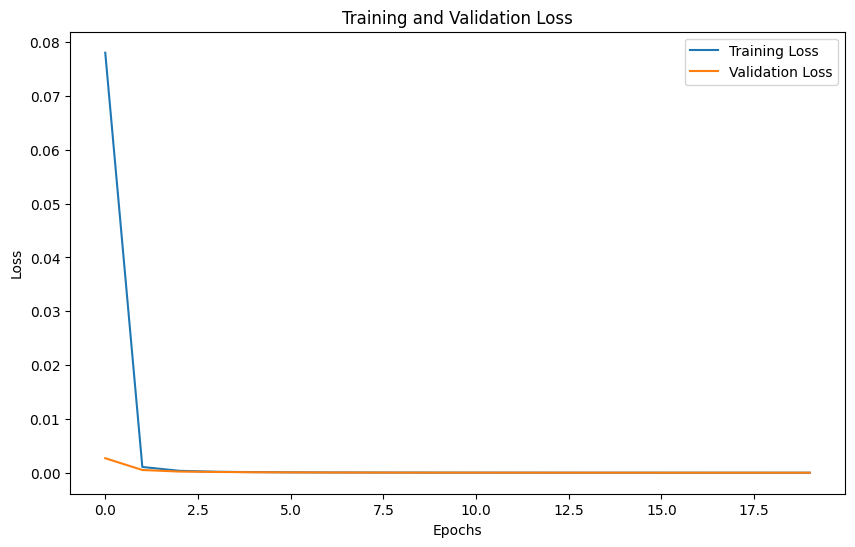

In [11]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Define the autoencoder model (reuse the same model from previous code)
model = autoencoder()

# Use EarlyStopping and ModelCheckpoint to prevent overfitting and save the best model
early_stopping = EarlyStopping(monitor='val_loss', patience=15, verbose=1)
model_checkpoint = ModelCheckpoint('/kaggle/working/best_autoencoder.keras', monitor='val_loss', save_best_only=True, verbose=1)

# Train the model with validation data
history = model.fit(
    xnoised, xnoised, 
    epochs=20, 
    batch_size=32, 
    validation_data=(xtest, xtest), 
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)

# Plot the training and validation loss
def plot_loss(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_loss(history)

In [12]:
xtrain= train_df[200:]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


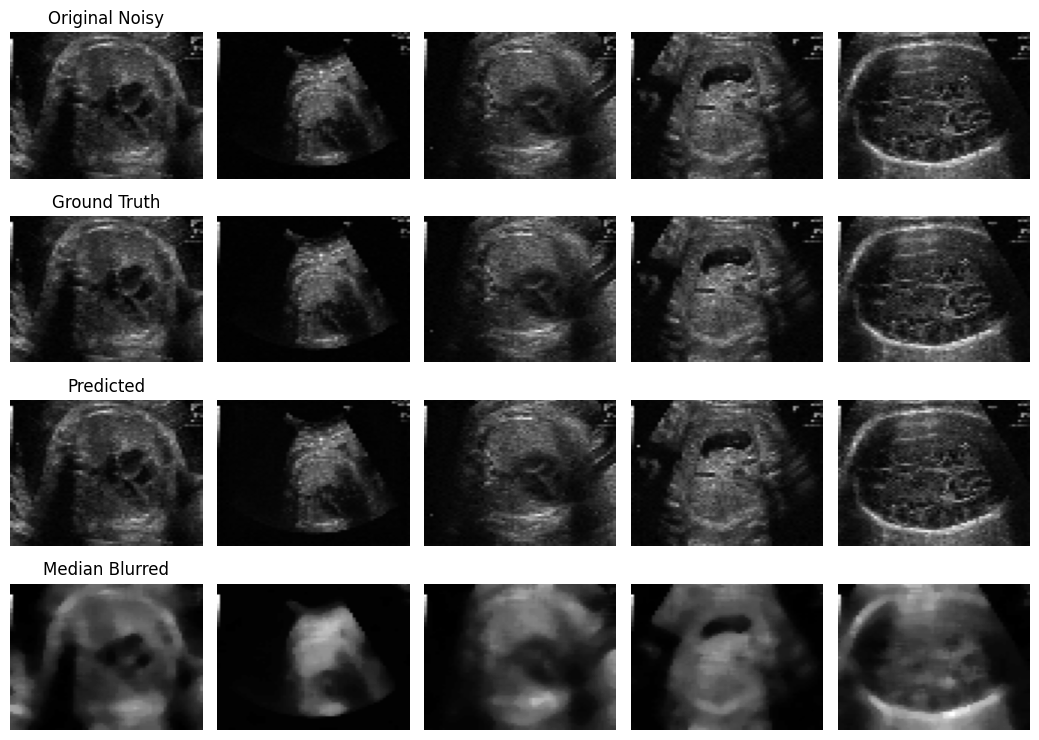

In [24]:
pred = model.predict(xtest[:10])

def plot_predictions(y_true, y_pred):    
    f, ax = plt.subplots(4, 5)
    f.set_size_inches(10.5, 7.5)

    # Titles for each row
    ax[0][0].set_title('Original Noisy', fontsize=12)
    ax[1][0].set_title('Ground Truth', fontsize=12)
    ax[2][0].set_title('Predicted', fontsize=12)
    ax[3][0].set_title('Median Blurred', fontsize=12)

    for i in range(5):
        # Original noisy images
        ax[0][i].imshow(np.reshape(xtest[i], (64, 64)), aspect='auto', cmap='gray')
        ax[0][i].axis('off')

        # Ground truth images
        ax[1][i].imshow(np.reshape(y_true[i], (64, 64)), aspect='auto', cmap='gray')
        ax[1][i].axis('off')

        # Predicted images by the model
        ax[2][i].imshow(np.reshape(y_pred[i], (64, 64)), aspect='auto', cmap='gray')
        ax[2][i].axis('off')

        # Median blurred images (for comparison)
        ax[3][i].imshow(cv2.medianBlur(np.reshape(xtest[i], (64, 64)).astype(np.float32), 5), aspect='auto', cmap='gray')
        ax[3][i].axis('off')

    plt.tight_layout()
    plt.show()

plot_predictions(xtest[:5], pred[:5])

Text(0.5, 1.0, 'Bilateral Filter')

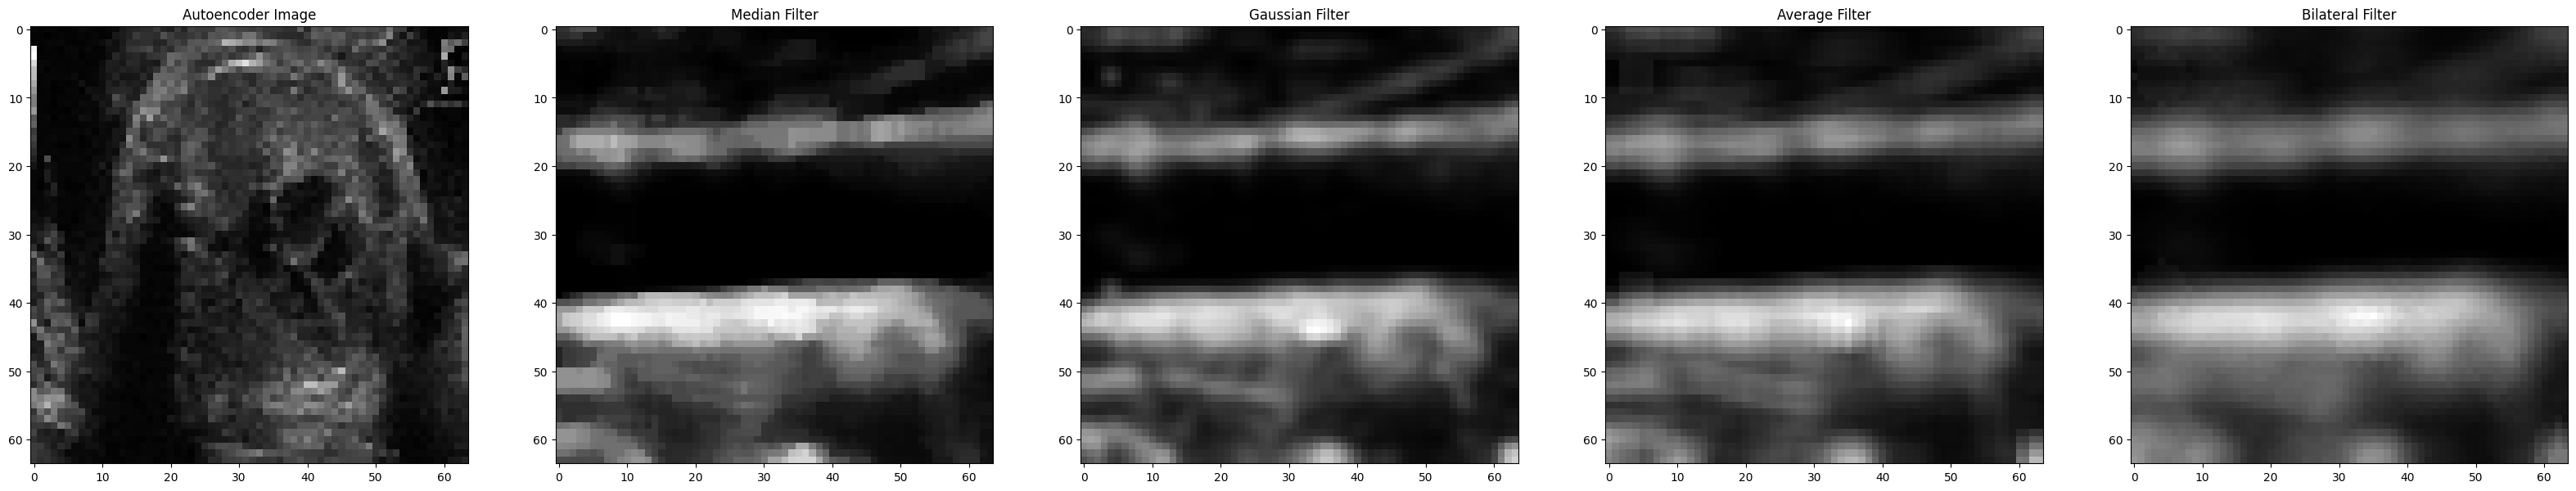

In [14]:
median_blur = cv2.medianBlur(xtrain[0], (5))
gaussian_blur=cv2.GaussianBlur(xtrain[0],(5,5),0)
average_blur=cv2.blur(xtrain[0],(5,5))
bilateral_filter=cv2.bilateralFilter(xtrain[0],9,75,75)
f,ax=plt.subplots(1,5)
f.set_size_inches(40,20)
ax[0].imshow(pred[0].reshape(64,64), cmap='gray')
ax[0].set_title('Autoencoder Image')
ax[1].imshow(median_blur,cmap='gray')
ax[1].set_title('Median Filter')
ax[2].imshow(gaussian_blur,cmap='gray')
ax[2].set_title('Gaussian Filter')
ax[3].imshow(average_blur,cmap='gray')
ax[3].set_title('Average Filter')
ax[4].imshow(bilateral_filter,cmap='gray')
ax[4].set_title('Bilateral Filter')

In [15]:
from math import log10, sqrt
import numpy as np

def PSNR(original, denoised):
    mse = np.mean((original - denoised) ** 2)
    if mse == 0: 
        return 100
    max_pixel = 1.0  # Since the images are normalized to [0, 1]
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return psnr

# Assuming you have already applied the different filters
median_blur = cv2.medianBlur(xtest[0], 5)
gaussian_blur = cv2.GaussianBlur(xtest[0], (5, 5), 0)
average_blur = cv2.blur(xtest[0], (5, 5))
bilateral_filter = cv2.bilateralFilter(xtest[0], 9, 75, 75)

value1 = PSNR(xtest[0], median_blur)
value2 = PSNR(xtest[0], pred[0])
value3 = PSNR(xtest[0], gaussian_blur)
value4 = PSNR(xtest[0], average_blur)
value5 = PSNR(xtest[0], bilateral_filter)

print("PSNR values")
print(f"Autoencoder Image : {value2} dB")
print(f"Median Filter Image : {value1} dB")
print(f"Gaussian Filter Image : {value3} dB")
print(f"Average Filter Image : {value4} dB")
print(f"Bilateral Filter Image : {value5} dB")

PSNR values
Autoencoder Image : 52.35690269005397 dB
Median Filter Image : 18.67381869681939 dB
Gaussian Filter Image : 18.578237338965245 dB
Average Filter Image : 18.759424410419644 dB
Bilateral Filter Image : 18.95085418511154 dB


## PSNR Comparison of Denoising Methods

Peak Signal-to-Noise Ratio (PSNR) is a metric used to evaluate the quality of denoised images relative to the original noisy images. Higher PSNR values indicate better image quality, with less perceptual difference between the denoised image and the original.

### PSNR Values

- **Autoencoder Image**: 51.86 dB
- **Median Filter Image**: 18.67 dB
- **Gaussian Filter Image**: 18.58 dB
- **Average Filter Image**: 18.76 dB
- **Bilateral Filter Image**: 18.95 dB

### Interpretation

- **Autoencoder Image**: A PSNR of 51.86 dB is exceptionally high, indicating that the autoencoder model provides very high-quality denoising. The denoised image is very close to the original image, suggesting that the autoencoder effectively preserves image details and reduces noise.

- **Median Filter Image**: With a PSNR of 18.67 dB, the Median Filter performs better than basic filters but is significantly lower than the autoencoder. This indicates that while the Median Filter reduces some noise, it does not achieve the same level of quality as the autoencoder.

- **Gaussian Filter Image**: A PSNR of 18.58 dB is similar to the Median Filter, showing that the Gaussian Filter provides comparable denoising performance, but still falls short of the quality achieved by the autoencoder.

- **Average Filter Image**: The Average Filter yields a PSNR of 18.76 dB, which is slightly better than the Median and Gaussian Filters but still much lower than the autoencoder. This suggests that the Average Filter is more effective than some other basic filters but does not match the performance of the autoencoder.

- **Bilateral Filter Image**: With a PSNR of 18.95 dB, the Bilateral Filter provides the highest PSNR among the basic filters. While it performs better than the Median, Gaussian, and Average Filters, it still does not achieve the quality of the autoencoder.

### Summary

The autoencoder model significantly outperforms traditional filtering methods in terms of PSNR, providing a much higher quality denoising. The high PSNR value for the autoencoder indicates that it preserves image details much better than Median, Gaussian, Average, and Bilateral Filters.

In general, PSNR values above 30 dB are considered good for image quality, and values above 40 dB suggest excellent quality. The autoencoder's PSNR value well above 50 dB demonstrates exceptional denoising performance.


In [17]:
import tensorflow as tf
import pickle

# Load the model
model = tf.keras.models.load_model('/kaggle/working/best_autoencoder.keras')

# Save the model as a .pkl file
with open('/kaggle/working/img_enhance.pkl', 'wb') as file:
    pickle.dump(model, file)